In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

from kim_filter import *
from lam_sysmat import *
from lam_constraints import *

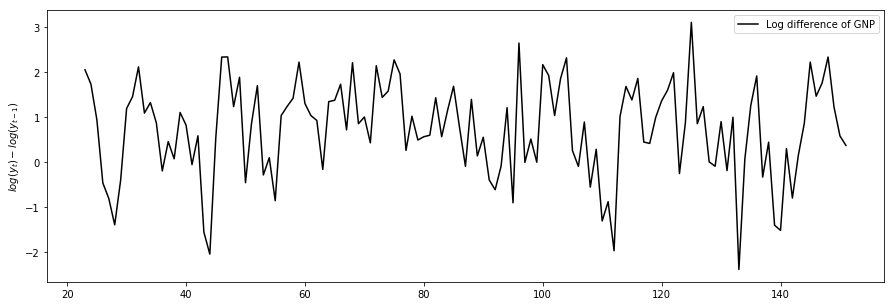

In [12]:
dados = pd.read_table('kim_je.prn', header=None, skipfooter=1,delim_whitespace=True, engine='python')

# Select data from 1952:2 to 1984:4
dados = dados[22:152]

# 100 times the log-difference
yy = 100*(np.log(dados[1])).diff().dropna()

# Plot data
fig=plt.figure(figsize=(15,5))
plt.plot(yy, color='k', label="Log difference of GNP")
plt.ylabel("$log(y_t) - log(y_{t-1})$")
plt.legend()
plt.savefig("logdiff.pdf")
plt.show()

yy = (yy.values).reshape((len(yy),1))

params0  = [3.5,0.0,0.5,1,0.7,-0.4, 1.7]
#params0 = [0.954, 0.465, -1.457, 2.42, 0.773, 1.246, -0.367, 5.224, 0.535]

In [13]:
def objective(params, model_constraints, model_ssf, Filter, y, log_start=0):

    params_const = model_constraints(params).T[0]
    mat = model_ssf(params_const, yy)
    result = kim_filter(mat, log_start)
    
    return -result

In [33]:
params_const = lam_constraints(params0).T[0]
mat = sys_mat(params_const, yy)

In [143]:
import numpy as np

"""
Author: Cássio Roberto de Andrade Alves
Date: september 2019
This code is based on Kim and Nelson (1999) "State-space models with regime switching" 
and very similar with the following matlab code:

https://github.com/bjdonhauser/ssmwrs

"""


def kim_filter(mat, log_start = 0):



    # NOTE: nObs+1 to take into account the intitial starting value

    '''
    1) S_t_j  -- Pr{S_t=j|I_t}: holds the filtered state inferences. (nObs+1 x nStates) array.

    2) S_l_j  -- Pr{S_t=j|I_{t-1}} holds the filtered state inferences. (nObs x nStates) array.
     
    3) b_tt_ij -- E{b_t|S_t=j, S_{t-1}=i,I_t}  holds the forecast of state variable for each date t, 
    corresponding to every possible value for i and j. (nObs+1 x lStateVec x nStates x nState) array

    3) b_tl_ij -- E{b_t|S_t=j, S_{t-1}=i,I_{t-1}}  holds the forecast of state variable for each date t, 
    corresponding to every possible value for i and j. (nObs+1 x lStateVec x nStates x nState) array
       
       
    4) b_tt_j -- E{b_t|S_t=j,I_t}  holds the filtered state variable inferences. 
       (nObs+1 x lStateVec x nStates) array
       
    5) P_tt_ij -- Cov{b_t|S_t=j, S_{t-1}=i,I_t} holds the filtered state variable covariance for each date t, 
    corresponding to every possible value for i and j. (nObs+1 x lStateVec x lStateVec x nStates x nStates) array

    6) P_tl_ij -- Cov{b_t|S_t=j, S_{t-1}=i,I_{t-1}} holds the filtered state variable covariance for each date t, 
    corresponding to every possible value for i and j. (nObs+1 x lStateVec x lStateVec x nStates x nStates) array

    7) P_tt_j  -- Cov{b_t|S_t=j, I_{t-1}}

    8) y_tl_ij -- E{y_t|S_t=j,S_{t-1}=i, I_{t-1}} holds the forecast for measurement variable for each date t, 
    corresponding to every possible value for i and j. (nObs x nMsrmntEqns x nStates x nStates).

    9) eta_tl_ij -- y_t - y_tl_ij  holds the forecast error of y_tl_ij for each date t, 
    corresponding to every possible value for i and j. (nObs x nMsrmntEqns x nStates x nStates).

    10) f_tl_ij  -- E{(y_t - y_tl_ij)(y_t - y_tl_ij)'|S_t=j,S_{t-1}=i, I_{t-1}} for each date t, 
    corresponding to every possible value for i and j. (nObs x nMsrmntEqns x nMsrmntEqns x nStates x nStates).
    '''

    #====================================================================#
    # Variables lengths
    #====================================================================#


    nObs        = np.shape(mat.y)[0]     # T
    lStatesVec  = np.shape(mat.b0[0])[0] # K 
    nStates     = np.shape(mat.prob)[0]  # M
    nMsrmntEqns = np.shape(mat.H[0])[0]  # N


    #====================================================================#
    # Alocating vector and matrices
    #====================================================================#

    logL = 0.0

    S_t_j = np.zeros((1, nObs+1,nStates))
    S_l_j = np.zeros((1, nObs+1,nStates))
    S_l_ij = np.zeros((1, nObs,nStates,nStates))
    S_t_ij = np.zeros((1, nObs, nStates,nStates))


    b_tt_ij = np.zeros((nStates,nStates,nObs,lStatesVec,1))
    b_tl_ij = np.zeros((nStates,nStates,nObs,lStatesVec,1))
    b_tt_j  = np.zeros((nStates,nObs+1,lStatesVec,1))

    P_tt_ij = np.zeros((nStates,nStates,nObs,lStatesVec,lStatesVec))
    P_tl_ij = np.zeros((nStates,nStates,nObs,lStatesVec,lStatesVec))
    P_tt_j  = np.zeros((nStates,nObs+1,lStatesVec,lStatesVec))

    y_tl_ij   = np.zeros((nStates,nStates,nObs,nMsrmntEqns,1))
    eta_tl_ij = np.zeros((nStates,nStates,nObs,nMsrmntEqns,1))
    f_tl_ij   = np.zeros((nStates,nStates,nObs,nMsrmntEqns,nMsrmntEqns))

    fy_l_ij_c  = np.zeros((nStates,nStates,nObs,nMsrmntEqns))
    fy_l_ij_uc = np.zeros((nStates,nStates,nObs,nMsrmntEqns))
    
    b_l = np.zeros((nObs,lStatesVec,1))
    P_l = np.zeros((1, nObs,lStatesVec, lStatesVec))
    y_l = np.zeros((1, nObs,nMsrmntEqns))
    eta_l = np.zeros((1, nObs,nMsrmntEqns))
    f_l = np.zeros((1, nObs,nMsrmntEqns, nMsrmntEqns))

    b_t = np.zeros((nObs,lStatesVec,1))
    P_t = np.zeros((1, nObs,lStatesVec, lStatesVec))        
    

    #========================================================================#
    # Starting Values
    #========================================================================#

    S_t_j[:,0]      = mat.S0.T
    b_tt_j[:,0,:]   = mat.b0
    P_tt_j[:,0,:,:] = mat.P0


    for t in range(nObs):
        
        
        
        #=====================================================================#
        # Kalman Filter (equations 5.10-5.15, pg. 100 (plus an extra step) )
        #=====================================================================#

        for i in range(nStates):
            for j in range(nStates):
                
                b_tl_ij[i,j,t,:]   = mat.mu[j] + np.dot(mat.F[j], b_tt_j[i,t,:])
                P_tl_ij[i,j,t,:,:] = np.dot(mat.F[j], P_tt_j[i,t,:,:]).dot(mat.F[j].T) + \
                                     np.dot(mat.G[j], mat.Q[j]).dot(mat.G[j].T)
                    
                
                y_tl_ij[i,j,t,:]   = np.dot(mat.H[j],b_tl_ij[i,j,t,:]) + np.dot(mat.A[j], mat.z[t])
                eta_tl_ij[i,j,t,:] = mat.y[t] - y_tl_ij[i,j,t,:]
                f_tl_ij[i,j,t,:,:] = np.dot(mat.H[j], P_tl_ij[i,j,t,:,:]).dot(mat.H[j].T) + mat.R[j]
                
                b_tt_ij[i,j,t,:]   = b_tl_ij[i,j,t,:] + \
                                     np.dot(np.dot(P_tl_ij[i,j,t,:,:], mat.H[j].T).dot(
                                     np.linalg.inv(f_tl_ij[i,j,t,:,:])), eta_tl_ij[i,j,t,:])
                P_tt_ij[i,j,t,:,:] = (np.eye(lStatesVec) - np.dot(np.dot(P_tl_ij[i,j,t,:,:],mat.H[j].T).dot(
                                     np.linalg.inv(f_tl_ij[i,j,t,:,:])), mat.H[j])).dot(P_tl_ij[i,j,t,:,:])
        
        #==================================================================#
        # Hamilton Filter (equations 5.18-5.23 in Kim and Nelson (1999, pgs.
        # 102-103) 
        #==================================================================#
        
        fy_l = 0.0
        
        for i in range(nStates):
            for j in range(nStates):
                
                #============================================================#
                # Steps 1  (Kim and Nelson (1999, pg. 102))
                #============================================================#
                	
                # (5.18) Pr{S_t=j,S_(t-1)=i|I_(t-1)} = Pr{S_t=j|S_(t-1)=i}*Pr{S_(t-1)=i|I_(t-1)}
                        
                S_l_ij[0,t,i,j] = mat.prob[i,j] * S_t_j[0,t,i]

                #============================================================#
                # Steps 2  (Kim and Nelson (1999, pg. 102))
                #============================================================#
                
                # eq. (5.21) f(y_t|S_t=j,S_(t-1)=i,I_(t-1)) = ...
                
                fy_l_ij_c[i,j,t,0] = (2*np.pi)**(-nMsrmntEqns/2) * (np.linalg.det(f_tl_ij[i,j,t,:,:]))**(-0.5) *\
                            np.exp(-0.5*np.dot(eta_tl_ij[i,j,t,:,0].T, np.linalg.inv(f_tl_ij[i,j,t,:,:])).dot(
                            eta_tl_ij[i,j,t,:,0]))

                # f(y_t,S_t=j,S_{t-1}=i|I_{t-1}) =
                # f(y_t|S_t=j,S_{t-1}=i,I_{t-1}) * Pr{S_t=j,S_(t-1)=i|I_(t-1)}
                
                fy_l_ij_uc[i,j,t,0] = fy_l_ij_c[i,j,t,0] * S_l_ij[0,t,i,j]
                
                # (5.20) f(y_t|I_(t-1)) = DoubleSum( f(y_t,S_t=j,S_(t-1)=i|I_(t-1)) )           
                fy_l = fy_l + fy_l_ij_uc[i,j,t,0]
                
        # (5.24) log(theta) = log(theta) + log(f(y_t|I_(t-1))
        if t>=log_start:

            logL = logL + np.log(fy_l)
        
        #==============================================#
        # Step 3 (Kim and Nelson (1999, pg. 103))
        #==============================================#
        # NOTE: There are extra steps taken here to get Pr{S_t=j|I_(t-1)} in
        # addition to Pr{S_t=j|I_t}
        
        for i in range(nStates):
            for j in range(nStates):
                
                # (5.22) Pr{S_t=j,S_(t-1)=i|I_t} =
                # f(y_t,S_t=j,S_(t-1)=i|I_(t-1)) / f(y_t|I_(t-1))
                
                S_t_ij[0,t,i,j] = fy_l_ij_uc[i,j,t,0]/fy_l
                
        # NOTE: the reversal of the order of iteration, which is necessary.
        
        for j in range(nStates):

            S_t_j[0,t+1,j] = 0 # NOTE: first entry not empty because of the initial values
            S_l_j[0,t+1,j] = 0 # NOTE: the first entry will be empty (zero?)

            for i in range(nStates):

                # (5.23) Pr{S_t=j|I_t} = sum_i( Pr{S_(t-1)=i,S_t=j|I_t} )
                S_t_j[0,t+1,j] = S_t_j[0,t+1,j] + S_t_ij[0,t,i,j]

                # Pr{S_t=j|I_(t-1)} = sum_i( Pr{S_(t-1)=i,S_t=j|I_t} )
                S_l_j[0,t+1,j] = S_l_j[0,t+1,j] + S_l_ij[0,t,i,j]
        
        
        #==================================================================#
        # Collapsing Terms (equations 5.16)
        #==================================================================#
        
        for j in range(nStates):
            b_tt_j[j,t+1,:] = (b_tt_j[j,t+1,:]*0).reshape(lStatesVec,1)
            for i in range(nStates):
                
                # (5.16) b_j_tt = Sum( Pr{S_(t-1)=i,S_t=j|I_t}*b_tt_ij ) /
                # Pr{S_t=j|I_(t-1)}
                b_tt_j[j,t+1,:] = b_tt_j[j,t+1,:] + S_t_ij[0,t,i,j] * b_tt_ij[i,j,t,:]
                
            b_tt_j[j,t+1,:] = b_tt_j[j,t+1,:] / S_t_j[0,t+1,j]
       
        #==================================================================#
        # Collapsing Terms (equations 5.17)
        #==================================================================#
        
        for j in range(nStates):
            P_tt_j[j,t+1,:,:] = ( P_tt_j[j,t+1,:,:]*0).reshape((lStatesVec,lStatesVec))
            for i in range(nStates):
                # (5.17') P_j_tt = Sum( Pr{S_(t-1)=i,S_t=j|I_t} * {P_tt_ij +
                # (b_j_tt - b_tt_ij)*(b_j_tt - b_tt_ij)'} ) / Pr{S_t=j|I_t}
                
                P_tt_j[j,t+1,:,:] = P_tt_j[j,t+1,:,:] + S_t_ij[0,t,i,j] *(P_tt_ij[i,j,t,:,:] + \
                    np.dot((b_tt_j[j,t+1,:] - b_tt_ij[i,j,t,:]), (b_tt_j[j,t,:] - b_tt_ij[i,j,t,:]).T))
        
            
            P_tt_j[j,t+1,:,:] = P_tt_j[j,t+1,:,:]/S_t_j[0,t+1,j]
            
        #=================================================================#
        # Collecting output
        #=================================================================#
        
        for i in range(nStates):
            for j in range(nStates):

                b_l[t,:]       = b_l[t,:] + b_tl_ij[i,j,t,:] * S_l_ij[0,t,i,j]
                P_l[0,t,:,:]   = P_l[0,t,:,:] +  P_tl_ij[i,j,t,:,:] * S_l_ij[0,t,i,j]
                y_l[0,t,:]     = y_l[0,t,:] + y_tl_ij[i,j,t,:] * S_l_ij[0,t,i,j]
                eta_l[0,t,:]   = eta_l[0,t,:] + eta_tl_ij[i,j,t,:] * S_l_ij[0,t,i,j]
                f_l[0,t,:,:]   = f_l[0,t,:,:] + f_tl_ij[i,j,t,:,:] * S_l_ij[0,t,i,j]

                b_t[t,:]       = b_t[t,:] + b_tt_ij[i,j,t,:] * S_t_ij[0,t,i,j]
                P_t[0,t,:,:]   = P_t[0,t,:,:] +  P_tt_ij[i,j,t,:,:] * S_t_ij[0,t,i,j]
        
        #=================================================================#
        # Fill output structure in a class
        #=================================================================#
        
    class Results:

        def __init__(self, logL, S_t_j, S_l_j, b_t, b_l, P_t, P_l, y_l, eta_l, f_l):

            self.logL  = logL
            self.S_t_j = S_t_j[0,1:,:]
            self.S_l_j = S_l_j[0,1:,:]
            self.b_t   = b_t[:,:,0]
            self.b_l   = b_l[:,:,0]
            self.P_t   = P_t[0,:,:,:]
            self.P_l   = P_l[0,:,:,:]
            self.y_l   = y_l[0,:,:]
            self.eta_l = eta_l[0,:,:]
            self.f_l   = f_l[0,:,:,:]
                
    results = Results(logL, S_t_j, S_l_j, b_t, b_l, P_t, P_l, y_l, eta_l, f_l)
                        
    return results

In [144]:
resultado = kim_filter(mat)

(129, 1, 1)

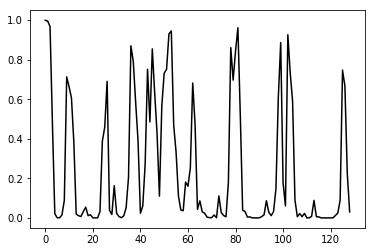

In [155]:
plt.plot(resultado.S_t_j[:,1],linestyle='-', color='k')
plt.show()

In [78]:
# NOTE: nObs+1 to take into account the intitial starting value

'''
1) S_t_j  -- Pr{S_t=j|I_t}: holds the filtered state inferences. (nObs+1 x nStates) array.

2) S_l_j  -- Pr{S_t=j|I_{t-1}} holds the filtered state inferences. (nObs x nStates) array.

3) b_tt_ij -- E{b_t|S_t=j, S_{t-1}=i,I_t}  holds the forecast of state variable for each date t, 
corresponding to every possible value for i and j. (nObs+1 x lStateVec x nStates x nState) array

3) b_tl_ij -- E{b_t|S_t=j, S_{t-1}=i,I_{t-1}}  holds the forecast of state variable for each date t, 
corresponding to every possible value for i and j. (nObs+1 x lStateVec x nStates x nState) array


4) b_tt_j -- E{b_t|S_t=j,I_t}  holds the filtered state variable inferences. 
   (nObs+1 x lStateVec x nStates) array

5) P_tt_ij -- Cov{b_t|S_t=j, S_{t-1}=i,I_t} holds the filtered state variable covariance for each date t, 
corresponding to every possible value for i and j. (nObs+1 x lStateVec x lStateVec x nStates x nStates) array

6) P_tl_ij -- Cov{b_t|S_t=j, S_{t-1}=i,I_{t-1}} holds the filtered state variable covariance for each date t, 
corresponding to every possible value for i and j. (nObs+1 x lStateVec x lStateVec x nStates x nStates) array

7) P_tt_j  -- Cov{b_t|S_t=j, I_{t-1}}

8) y_tl_ij -- E{y_t|S_t=j,S_{t-1}=i, I_{t-1}} holds the forecast for measurement variable for each date t, 
corresponding to every possible value for i and j. (nObs x nMsrmntEqns x nStates x nStates).

9) eta_tl_ij -- y_t - y_tl_ij  holds the forecast error of y_tl_ij for each date t, 
corresponding to every possible value for i and j. (nObs x nMsrmntEqns x nStates x nStates).

10) f_tl_ij  -- E{(y_t - y_tl_ij)(y_t - y_tl_ij)'|S_t=j,S_{t-1}=i, I_{t-1}} for each date t, 
corresponding to every possible value for i and j. (nObs x nMsrmntEqns x nMsrmntEqns x nStates x nStates).
'''

#====================================================================#
# Variables lengths
#====================================================================#


nObs        = np.shape(mat.y)[0]     # T
lStatesVec  = np.shape(mat.b0[0])[0] # K 
nStates     = np.shape(mat.prob)[0]  # M
nMsrmntEqns = np.shape(mat.H[0])[0]  # N


#====================================================================#
# Alocating vector and matrices
#====================================================================#

logL = 0.0

S_t_j = np.zeros((1, nObs+1,nStates))
S_l_j = np.zeros((1, nObs+1,nStates))
S_l_ij = np.zeros((1, nObs,nStates,nStates))
S_t_ij = np.zeros((1, nObs, nStates,nStates))


b_tt_ij = np.zeros((nStates,nStates,nObs,lStatesVec,1))
b_tl_ij = np.zeros((nStates,nStates,nObs,lStatesVec,1))
b_tt_j  = np.zeros((nStates,nObs+1,lStatesVec,1))

P_tt_ij = np.zeros((nStates,nStates,nObs,lStatesVec,lStatesVec))
P_tl_ij = np.zeros((nStates,nStates,nObs,lStatesVec,lStatesVec))
P_tt_j  = np.zeros((nStates,nObs+1,lStatesVec,lStatesVec))

y_tl_ij   = np.zeros((nStates,nStates,nObs,nMsrmntEqns,1))
eta_tl_ij = np.zeros((nStates,nStates,nObs,nMsrmntEqns,1))
f_tl_ij   = np.zeros((nStates,nStates,nObs,nMsrmntEqns,nMsrmntEqns))

fy_l_ij_c  = np.zeros((nStates,nStates,nObs,nMsrmntEqns))
fy_l_ij_uc = np.zeros((nStates,nStates,nObs,nMsrmntEqns))

b_l = np.zeros((nObs,lStatesVec,1))
P_l = np.zeros((1, nObs,lStatesVec, lStatesVec))
y_l = np.zeros((1, nObs,nMsrmntEqns))
eta_l = np.zeros((1, nObs,nMsrmntEqns))
f_l = np.zeros((1, nObs,nMsrmntEqns, nMsrmntEqns))

b_t = np.zeros((nObs,lStatesVec,1))
P_t = np.zeros((1, nObs,lStatesVec, lStatesVec))    


#========================================================================#
# Starting Values
#========================================================================#

S_t_j[:,0]      = mat.S0.T
b_tt_j[:,0,:]   = mat.b0
P_tt_j[:,0,:,:] = mat.P0


for t in range(nObs):



    #=====================================================================#
    # Kalman Filter (equations 5.10-5.15, pg. 100 (plus an extra step) )
    #=====================================================================#

    for i in range(nStates):
        for j in range(nStates):

            b_tl_ij[i,j,t,:]   = mat.mu[j] + np.dot(mat.F[j], b_tt_j[i,t,:])
            P_tl_ij[i,j,t,:,:] = np.dot(mat.F[j], P_tt_j[i,t,:,:]).dot(mat.F[j].T) + \
                                 np.dot(mat.G[j], mat.Q[j]).dot(mat.G[j].T)


            y_tl_ij[i,j,t,:]   = np.dot(mat.H[j],b_tl_ij[i,j,t,:]) + np.dot(mat.A[j], mat.z[t])
            eta_tl_ij[i,j,t,:] = mat.y[t] - y_tl_ij[i,j,t,:]
            f_tl_ij[i,j,t,:,:] = np.dot(mat.H[j], P_tl_ij[i,j,t,:,:]).dot(mat.H[j].T) + mat.R[j]

            b_tt_ij[i,j,t,:]   = b_tl_ij[i,j,t,:] + \
                                 np.dot(np.dot(P_tl_ij[i,j,t,:,:], mat.H[j].T).dot(
                                 np.linalg.inv(f_tl_ij[i,j,t,:,:])), eta_tl_ij[i,j,t,:])
            P_tt_ij[i,j,t,:,:] = (np.eye(lStatesVec) - np.dot(np.dot(P_tl_ij[i,j,t,:,:],mat.H[j].T).dot(
                                 np.linalg.inv(f_tl_ij[i,j,t,:,:])), mat.H[j])).dot(P_tl_ij[i,j,t,:,:])

    #==================================================================#
    # Hamilton Filter (equations 5.18-5.23 in Kim and Nelson (1999, pgs.
    # 102-103) 
    #==================================================================#

    fy_l = 0.0

    for i in range(nStates):
        for j in range(nStates):

            #============================================================#
            # Steps 1  (Kim and Nelson (1999, pg. 102))
            #============================================================#

            # (5.18) Pr{S_t=j,S_(t-1)=i|I_(t-1)} = Pr{S_t=j|S_(t-1)=i}*Pr{S_(t-1)=i|I_(t-1)}

            S_l_ij[0,t,i,j] = mat.prob[i,j] * S_t_j[0,t,i]

            #============================================================#
            # Steps 2  (Kim and Nelson (1999, pg. 102))
            #============================================================#

            # eq. (5.21) f(y_t|S_t=j,S_(t-1)=i,I_(t-1)) = ...

            fy_l_ij_c[i,j,t,0] = (2*np.pi)**(-nMsrmntEqns/2) * (np.linalg.det(f_tl_ij[i,j,t,:,:]))**(-0.5) *\
                        np.exp(-0.5*np.dot(eta_tl_ij[i,j,t,:,0].T, np.linalg.inv(f_tl_ij[i,j,t,:,:])).dot(
                        eta_tl_ij[i,j,t,:,0]))

            # f(y_t,S_t=j,S_{t-1}=i|I_{t-1}) =
            # f(y_t|S_t=j,S_{t-1}=i,I_{t-1}) * Pr{S_t=j,S_(t-1)=i|I_(t-1)}

            fy_l_ij_uc[i,j,t,0] = fy_l_ij_c[i,j,t,0] * S_l_ij[0,t,i,j]

            # (5.20) f(y_t|I_(t-1)) = DoubleSum( f(y_t,S_t=j,S_(t-1)=i|I_(t-1)) )           
            fy_l = fy_l + fy_l_ij_uc[i,j,t,0]

    # (5.24) log(theta) = log(theta) + log(f(y_t|I_(t-1))
    if t>=log_start:

        logL = logL + np.log(fy_l)

    #==============================================#
    # Step 3 (Kim and Nelson (1999, pg. 103))
    #==============================================#
    # NOTE: There are extra steps taken here to get Pr{S_t=j|I_(t-1)} in
    # addition to Pr{S_t=j|I_t}

    for i in range(nStates):
        for j in range(nStates):

            # (5.22) Pr{S_t=j,S_(t-1)=i|I_t} =
            # f(y_t,S_t=j,S_(t-1)=i|I_(t-1)) / f(y_t|I_(t-1))

            S_t_ij[0,t,i,j] = fy_l_ij_uc[i,j,t,0]/fy_l

    # NOTE: the reversal of the order of iteration, which is necessary.

    for j in range(nStates):

        S_t_j[0,t+1,j] = 0 # NOTE: first entry not empty because of the initial values
        S_l_j[0,t+1,j] = 0 # NOTE: the first entry will be empty (zero?)

        for i in range(nStates):

            # (5.23) Pr{S_t=j|I_t} = sum_i( Pr{S_(t-1)=i,S_t=j|I_t} )
            S_t_j[0,t+1,j] = S_t_j[0,t+1,j] + S_t_ij[0,t,i,j]

            # Pr{S_t=j|I_(t-1)} = sum_i( Pr{S_(t-1)=i,S_t=j|I_t} )
            S_l_j[0,t+1,j] = S_l_j[0,t+1,j] + S_l_ij[0,t,i,j]


    #==================================================================#
    # Collapsing Terms (equations 5.16)
    #==================================================================#

    for j in range(nStates):
        b_tt_j[j,t+1,:] = (b_tt_j[j,t+1,:]*0).reshape(lStatesVec,1)
        for i in range(nStates):

            # (5.16) b_j_tt = Sum( Pr{S_(t-1)=i,S_t=j|I_t}*b_tt_ij ) /
            # Pr{S_t=j|I_(t-1)}
            b_tt_j[j,t+1,:] = b_tt_j[j,t+1,:] + S_t_ij[0,t,i,j] * b_tt_ij[i,j,t,:]

        b_tt_j[j,t+1,:] = b_tt_j[j,t+1,:] / S_t_j[0,t+1,j]

    #==================================================================#
    # Collapsing Terms (equations 5.17)
    #==================================================================#

    for j in range(nStates):
        P_tt_j[j,t+1,:,:] = ( P_tt_j[j,t+1,:,:]*0).reshape((lStatesVec,lStatesVec))
        for i in range(nStates):
            # (5.17') P_j_tt = Sum( Pr{S_(t-1)=i,S_t=j|I_t} * {P_tt_ij +
            # (b_j_tt - b_tt_ij)*(b_j_tt - b_tt_ij)'} ) / Pr{S_t=j|I_t}

            P_tt_j[j,t+1,:,:] = P_tt_j[j,t+1,:,:] + S_t_ij[0,t,i,j] *(P_tt_ij[i,j,t,:,:] + \
                np.dot((b_tt_j[j,t+1,:] - b_tt_ij[i,j,t,:]), (b_tt_j[j,t,:] - b_tt_ij[i,j,t,:]).T))


        P_tt_j[j,t+1,:,:] = P_tt_j[j,t+1,:,:]/S_t_j[0,t+1,j]

    #=================================================================#
    # Collecting output
    #=================================================================#

    for i in range(nStates):
        for j in range(nStates):

            b_l[t,:]       = b_l[t,:] + b_tl_ij[i,j,t,:] * S_l_ij[0,t,i,j]
            P_l[0,t,:,:]   = P_l[0,t,:,:] +  P_tl_ij[i,j,t,:,:] * S_l_ij[0,t,i,j]
            y_l[0,t,:]     = y_l[0,t,:] + y_tl_ij[i,j,t,:] * S_l_ij[0,t,i,j]
            eta_l[0,t,:]   = eta_l[0,t,:] + eta_tl_ij[i,j,t,:] * S_l_ij[0,t,i,j]
            f_l[0,t,:,:]   = f_l[0,t,:,:] + f_tl_ij[i,j,t,:,:] * S_l_ij[0,t,i,j]
            
            b_t[t,:]       = b_t[t,:] + b_tt_ij[i,j,t,:] * S_t_ij[0,t,i,j]
            P_t[0,t,:,:]   = P_t[0,t,:,:] +  P_tt_ij[i,j,t,:,:] * S_t_ij[0,t,i,j]
            